# Setup the weights of popularity

The correlation calculation considers every rating however if a movie is rating by one hundred people should have more reliable relationships than the movie rated by only five people.

## Analysis

Generate the `movie_ratings.csv` so rating counts by movies will be precalculated.

In [31]:
from os.path import exists

from models.spark import preprocessing as pp

if not exists('../data/processed/movie_ratings.csv'):
    pp.load_and_transform(dataset='ml-100k')

Load the `movie_ratings.csv` to a dataframe and create a histogram to see the distribution of movies by their rating count.

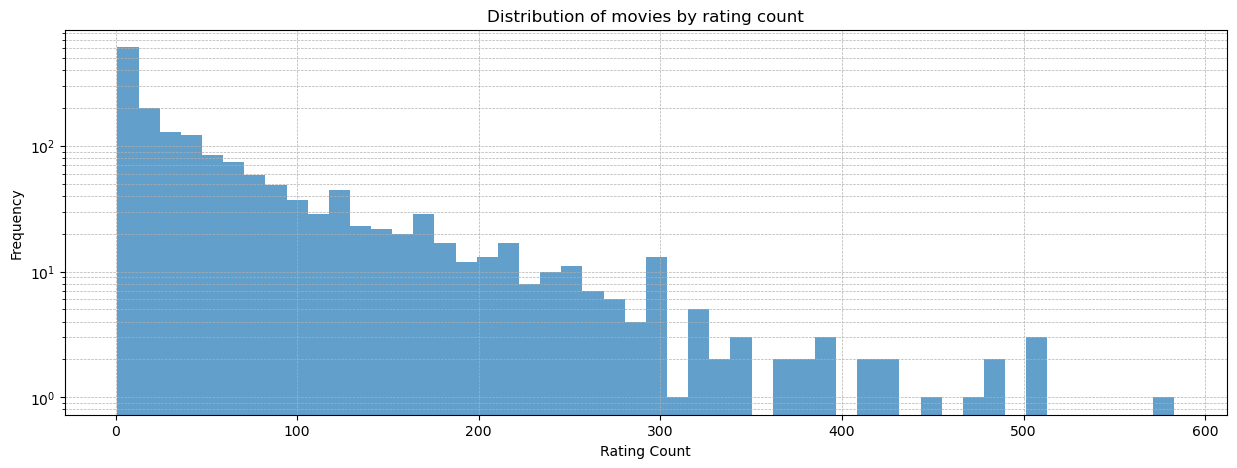

In [32]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/movie_ratings.csv', usecols=['movieId', 'title', 'rating', 'ratingCount'])


def hist_rating_count_distribution(data, bins, label):
    plt.figure(figsize=(15, 5))
    plt.hist(data['ratingCount'], bins=bins, alpha=0.7, label=label)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.grid(True)
    plt.title('Distribution of movies by rating count')
    plt.xlabel('Rating Count')
    plt.ylabel('Frequency')
    plt.yscale('log')


hist_rating_count_distribution(df, label='Rating Count Distribution', bins=50)
plt.show()

Now create a function that have a weak preference for movies that have more rating count than 100 ratings and also starts to heavily underweight movies with low amount of ratings.

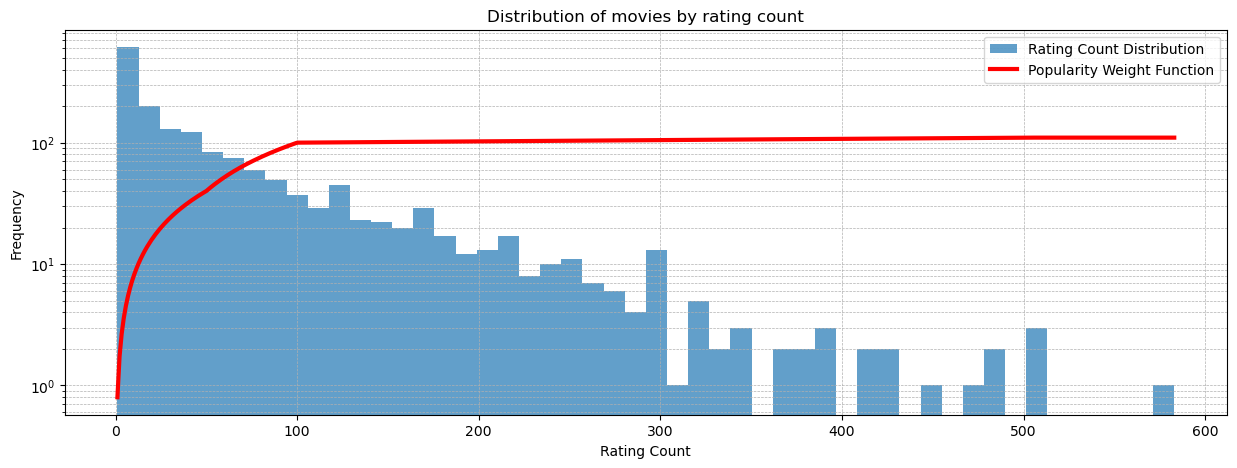

In [33]:
import numpy as np


def planned_popularity_weight(rating_count):
    rating_counts = [0, 50, 100, 300, 500]
    weights = [0, 0.4, 1, 1.05, 1.1]
    return np.interp(rating_count, rating_counts, weights)


def plot_popularity_weight(data, scale: int, color, label, weight_function, line_width=3, line_type="-"):
    rating_count_range = np.linspace(data['ratingCount'].min(), data['ratingCount'].max(), 500)
    popularity_weights = weight_function(rating_count_range)

    plt.plot(rating_count_range, popularity_weights * scale, line_type, color=color, label=label, linewidth=line_width)


hist_rating_count_distribution(df, label='Rating Count Distribution', bins=50)

plot_popularity_weight(df, label='Popularity Weight Function',
                       weight_function=planned_popularity_weight, scale=100, color='red')

plt.legend()
plt.show()

The weight function looks good now however the values that were used for interpolation depends on the dataset. I want to create a function that can automatically adjust itself to the data. I feel that the function too quickly changes around a hundred. Try to smooth out the dynamic version

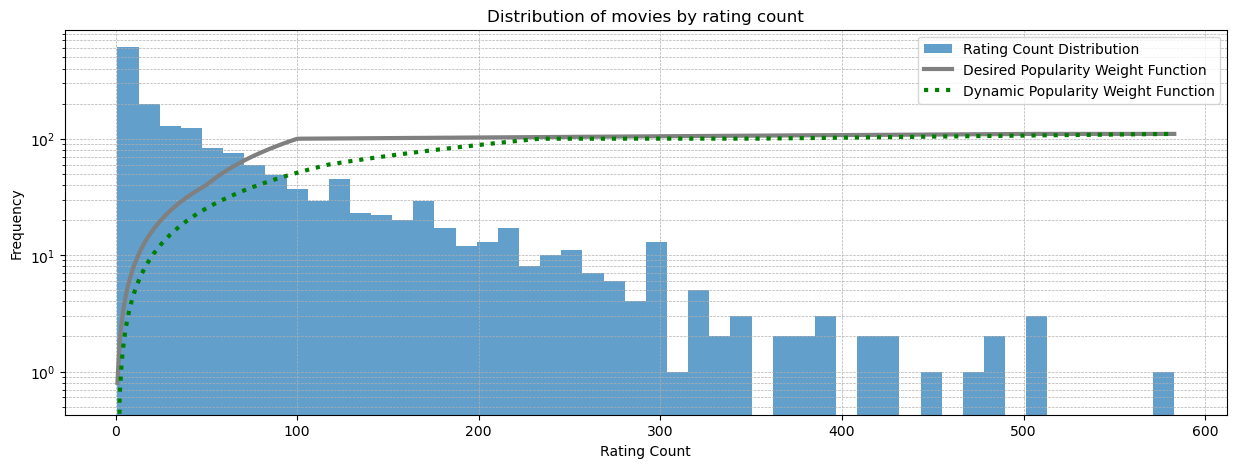

In [34]:
def dynamic_popularity_weight(rating_count):
    min_count = df['ratingCount'].min()
    max_count = df['ratingCount'].max()
    weights = [0, 0.6, 1, 1, 1.05, 1.1]

    rating_counts = np.linspace(min_count, max_count, len(weights))

    return np.interp(rating_count, rating_counts, weights)


hist_rating_count_distribution(df,
                               label='Rating Count Distribution', bins=50)

plot_popularity_weight(df,
                       label='Desired Popularity Weight Function',
                       weight_function=planned_popularity_weight, scale=100, color='gray')
plot_popularity_weight(df,
                       label='Dynamic Popularity Weight Function',
                       weight_function=dynamic_popularity_weight, scale=100, color='green', line_width=3, line_type=":")

plt.legend()
plt.show()

## Actual implementation

I created a class for doing all this work so visualize how it weight the rating counts. 

It has three profile:

- `NORMAL`: It prefers popular movies and decreases the weight when the rating count closes to zero
- `POPULAR`: It strongly prefers popular movies as the rating count increases to the weight
- `UNPOPULAR`: It punishes movies with high rating count
- `NONE`: All movies have weight 1


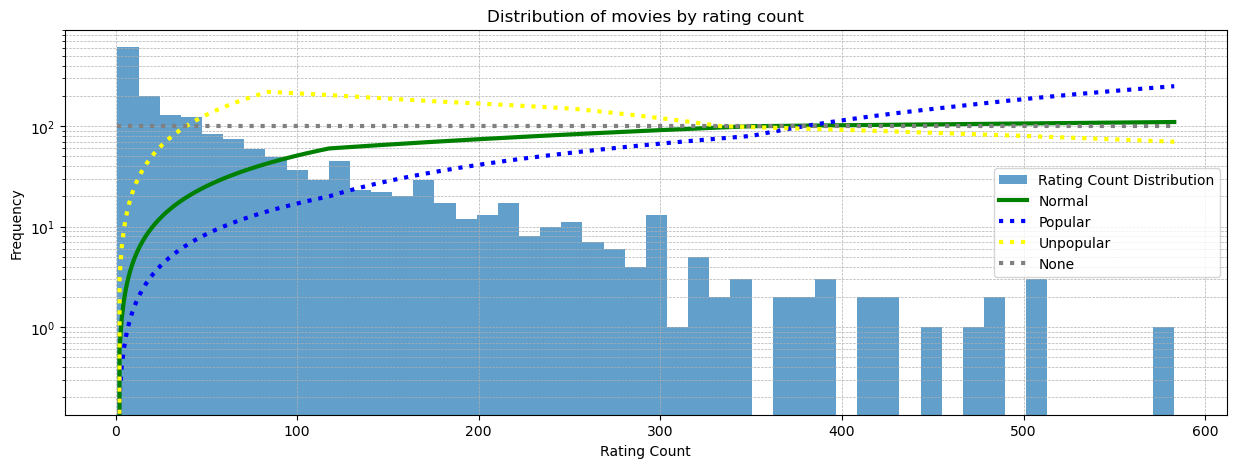

In [35]:
from models.weights import PopularityWeightFactor, PopularityPreference

factor = PopularityWeightFactor(df['ratingCount'].min(), df['ratingCount'].max())

hist_rating_count_distribution(df, label='Rating Count Distribution', bins=50)

plot_popularity_weight(df,
                       label='Normal', color='green', line_width=3, line_type="-",
                       weight_function=lambda c: factor.weight(c, PopularityPreference.NORMAL), scale=100)

plot_popularity_weight(df,
                       label='Popular', color='blue', line_width=3, line_type=":",
                       weight_function=lambda c: factor.weight(c, PopularityPreference.POPULAR), scale=100)

plot_popularity_weight(df,
                       label='Unpopular', color='yellow', line_width=3, line_type=":",
                       weight_function=lambda c: factor.weight(c, PopularityPreference.UNPOPULAR), scale=100)

plot_popularity_weight(df,
                       label='None', color='gray', line_width=3, line_type=":",
                       weight_function=lambda c: factor.weight(c, PopularityPreference.NONE), scale=100)

plt.legend()
plt.show()